In [1]:
#import libraries
import torch 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch import optim, nn, sigmoid

In [2]:
#import data from Project-1
df = pd.read_csv('dataset.csv', index_col = 0)
df = df.astype({'budget': 'Int64', 'US_box_office': 'Int64', 'box_office': 'Int64'})

## Introduction

In the Project-1 I've analyzed data taken from the IMDB website. There were around 800 movies. Intuitively the collected data can be split into two types. First group is the data known before the release of the movie (Title, Director, Year Genre, Country, Language, Budget), second group is the data known after(BoxOffices, User Ratings). Metacritic score is usually calculated just before the release and its results affect the viewers decision to watch. I've decided to predict user_rating based on the following variables: Genre, Country Language, Budget, Metacritic Score. I don't want to use director and year because they are almost unique for each movie. If I had a dataset of hundreds of thousands movies they would've helped. I don't expect any of the models to have higher accuracy, because we need much more input variables such as director, main actors etc. However if I spend time collecting additional data, I would need a very huge dataset consisting of several movies of each director and actor. Therefore I kept my original dataset and used the most appropriate columns for prediction. Language, Country and Genre are categorical data, so they were converted using dummies. Moreover we have to mean normalize Budget and Metacritic scores for the  prediction to be more accurate. 

In [3]:
#select the subset for modeling
df = df.dropna(subset = ['title','country','genre','language','budget','metacritic','usr_rating'])
#normalize budget and metacritic
df.budget = (df.budget - df.budget.min())/(df.budget.max() - df.budget.min())
df.metacritic = (df.metacritic - df.metacritic.min())/(df.metacritic.max() - df.metacritic.min())
dn = df[['title','country','genre', 'language','budget','metacritic']].reset_index(drop = True)
out = df.usr_rating.reset_index(drop = True)
#change categorical data using dummies
inp = pd.get_dummies(dn, columns = ['country','genre','language'], prefix = ['c','g','l'])
print(inp.shape)
#set seed
torch.manual_seed(0)

(255, 58)


The initial dataset shortened after dropping null values, but extended after applying pandas.get_dummies on language, country and genre, so the final shape is [255,58]. Next, create Data class using torch.utils.Dataset

In [4]:
#define class Data using Dataset in torch.utils.data
class Data(Dataset):
    
    def __init__(self):
        j = 0
        self.title = inp.title
        self.x = torch.zeros(255, 58)
        for i in range (1,len(inp.columns)):
            self.x[:, j] = torch.tensor(inp[inp.columns[i]].values)
            j = j+1
        self.y = torch.tensor(out.values, dtype = torch.float32)
        self.len = self.x.shape[0]
            
    def __getitem__(self, index):    
        return self.title[index], self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

Now the data needs to be initialized and then split into training, validation and test splits. Since I have only 255 instances I want to use as much rows as possible for the training. So I decided to split them by 80/10/10 ratio randomly. 

Train split size = 204
Validation split size = 26
Test split size = 25

In [5]:
#create dataset for modeling and split it into training, validatio and training
dataset = Data()
train_size = 204
val_size = 26
test_size = 25
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

## Models and training

I've defined the Net class using nn.Module. It is universal for all the models and allows to create any number of layers when initializing the model without the modification of the class. 

In [6]:
#model for neural networks
class Model(nn.Module):
    
    def __init__(self, Layers):
        super(Model, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = torch.relu(linear_transform(activation))    
            else:
                activation = linear_transform(activation)
        return activation

Training function looks as following. It is built in such a way that we can evaluate the hyperparameters using validation set. It returns a dictionary consisting of two arrays of losses: for training and validation splits.

In [7]:
#define training function
def train(train_loader, model, criterion, val_loader, optimizer, epochs):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        for t, x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
               
        for t, x, y in val_loader:
            optimizer.zero_grad()
            with torch.no_grad():
                lossv = criterion(model(x), y)     
                assert lossv.requires_grad == False
        train_loss.append(loss.item())
        val_loss.append(lossv.item())
        
    results ={"train_loss":train_loss, "val_loss":val_loss}
    return results

### Linear Regression
Since I have a continuous output I did the linear regression model for the first part. Learning rate was initialized randomly but then tuned using validation split. Also optimizer and criterion were chosen appropriately for the model. For all three models I've used MSELoss()

In [8]:
lin_model = Model([58,1])
lin_optimizer = optim.Adam(lin_model.parameters(), lr=0.01)
lin_criterion = nn.MSELoss()
lin_train_loader = DataLoader(dataset=train_set, batch_size = 5)
lin_val_loader = DataLoader(dataset=val_set)
lin_train = train(lin_train_loader, lin_model, lin_criterion, lin_val_loader, lin_optimizer, epochs = 200)

/usr/local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, 

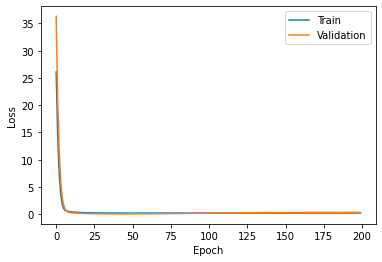

In [9]:
plt.plot(lin_train['train_loss'], label = 'Train')
plt.plot(lin_train['val_loss'], label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As we can see from the graph, there is no overfitting and losses converge to 0. Both losses behave almost the same

### Shallow Neural Network (SNN)
Next model is SNN. The number of neurons in the hidden layer, learning_rate and the batch_size were intialized randomly and then modified with the validation split. 

In [10]:
SNN_model = Model([58,10,1])
SNN_optimizer = optim.SGD(SNN_model.parameters(), lr=0.001)
SNN_train_loader = DataLoader(dataset=train_set, batch_size=5)
SNN_val_loader = DataLoader(dataset=val_set)
SNN_criterion = nn.MSELoss()
SNN_train = train(SNN_train_loader, SNN_model, SNN_criterion, SNN_val_loader, SNN_optimizer, epochs=100)

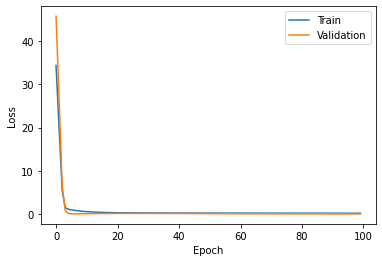

In [11]:
plt.plot(SNN_train['train_loss'], label = 'Train')
plt.plot(SNN_train['val_loss'], label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As we can see from the graph, there is no overfitting and losses converge to 0. Both losses behave almost the same

### Deep Neural Network(DNN)
For the DNN I've decided using 3 hidden layers with 10 neurons each. All the hyperparameters tuned using validation split

In [12]:
DNN_model = Model([58,10,10,10,1])
DNN_optimizer = torch.optim.Adam(DNN_model.parameters(), lr=0.001)
DNN_train_loader = DataLoader(dataset=train_set, batch_size=2)
DNN_val_loader = DataLoader(dataset=val_set)
DNN_criterion = nn.MSELoss()
DNN_train = train(DNN_train_loader, DNN_model, DNN_criterion, DNN_val_loader, DNN_optimizer, epochs=100)

/usr/local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


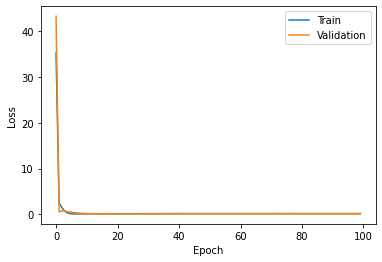

In [13]:
plt.plot(DNN_train['train_loss'], label = 'Train')
plt.plot(DNN_train['val_loss'], label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As we can see from the graph, there is no overfitting and losses converge to 0. Both losses behave almost the same

## Results on test split

Let's see the parameters of each model

In [14]:
print('Linear Regression\n', lin_model.state_dict())
print('SNN\n', SNN_model.state_dict())
print('DNN\n', DNN_model.state_dict())

Linear Regression
 OrderedDict([('hidden.0.weight', tensor([[ 0.2312,  0.6776,  1.2880,  1.0448,  1.5711,  1.3329,  1.2739,  1.2741,
          1.2955,  1.9039,  1.1342,  1.3197,  1.1758,  0.8578,  1.3512,  1.2044,
          0.9434,  1.0324,  1.4972,  1.1091,  1.1865,  1.1331,  0.1151,  1.1704,
          1.1337,  1.6132,  1.4236,  1.4985,  1.5246,  1.4093,  1.3568,  1.4362,
          1.3765,  1.4025,  1.3700,  1.3570,  1.3824,  1.7642,  1.7220,  1.6486,
          1.6879,  2.1649,  1.3168,  1.4037,  1.3625,  1.3442,  1.3915,  1.2361,
          1.1751,  1.1989,  1.2859,  1.0343,  1.2770,  1.4547,  1.4725,  1.3989,
         -0.1076, -0.0202]])), ('hidden.0.bias', tensor([2.4730]))])
SNN
 OrderedDict([('hidden.0.weight', tensor([[ 4.0934e-02, -1.2665e-01, -1.2756e-01,  1.6659e-02, -9.4594e-02,
         -1.1503e-01, -5.0591e-02, -2.1140e-02, -1.1932e-01, -8.7677e-02,
          3.9035e-03, -1.2382e-01, -1.8456e-02, -8.4785e-02, -9.1027e-02,
          5.1608e-02, -1.0107e-01, -9.9509e-02,  7.4

The function below applies models to the training split, plots barchart and returns pandas dataframe

In [15]:
#function that plots the barchart and returns table
def testvalues(test_set, lin_model, SNN_model, DNN_model):
    Titles = test_set[:][0].reset_index(drop = True)
    X = test_set[:][1]
    linYhat = np.around(torch.transpose(lin_model(X), 0, 1).reshape(-1).detach().numpy(), decimals = 3)
    SNNYhat = np.around(torch.transpose(SNN_model(X), 0, 1).reshape(-1).detach().numpy(), decimals = 3)
    DNNYhat = np.around(torch.transpose(DNN_model(X), 0, 1).reshape(-1).detach().numpy(), decimals = 3)
    Y = test_set[:][2].detach().numpy()
    dict = {'Title': Titles, 'True Values': Y, 'Linear':linYhat, 'SNN':SNNYhat, 'DNN':DNNYhat}
    testdf = pd.DataFrame(dict)
    indexed = testdf.set_index('Title')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10),gridspec_kw={'width_ratios': [1,1]})
    indexed.plot.barh(ax=ax1, xlabel = '', fontsize = 10)
    ax1.xaxis.tick_top()
    ax1.invert_yaxis()
    ax1.legend(loc='upper left')
    tb = ax2.table(cellText=indexed.values, 
              colColours = ['C0','C1','C2','C3'],
              colLabels = ['True Values', 'Linear', 'SNN', 'DNN'], 
              colWidths = [.25,.25,.25,.25],
              loc = 'center')
    cellDict = tb.get_celld()
    for i in range(0,len(indexed.columns)):
        cellDict[(0,i)].set_height(.021)
        cellDict[(0,i)]._text.set_color('white')
        cellDict[(0,i)]._text.set_weight('bold')
        for j in range(1,len(testdf[:])+1):
            cellDict[(j,i)].set_height(.04)
    tb.auto_set_font_size(False)
    tb.set_fontsize(10)
    ax2.axis('off')
    fig.show()
    return indexed.transpose()
pd.set_option('display.max_columns', None)

<ipython-input-15-6dd4fb2fea9e>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Title,Toy Story,King of California,Thief,Find Me Guilty,The Imitation Game,Cruel Intentions,The Freshman,Tomboy,Spy,The Peanut Butter Falcon,Strangers with Candy,Draft Day,The School of Rock,The Last Starfighter,Breaking Upwards,Batman Begins,Awakenings,Sky Blue,Buffalo Soldiers,1945,The Dirty Dozen,Turbo Kid,Orlando,Billy Lynn's Long Halftime Walk,Click
True Values,8.300,6.600,7.400,7.000,8.000,6.800,6.400,7.400,7.000,7.600,6.000,6.800,7.100,6.800,6.200,8.200,7.800,6.700,6.800,7.100,7.700,6.700,7.200,6.200,6.400
Linear,7.179,6.792,6.961,7.044,6.950,6.790,6.894,6.854,6.942,6.840,6.751,6.776,6.922,6.886,7.109,6.910,6.920,6.826,6.781,6.780,6.964,6.978,6.956,6.827,6.670
SNN,7.325,6.917,7.225,7.199,7.165,6.877,7.180,7.114,7.173,7.039,6.812,6.842,7.250,7.033,6.455,7.085,7.195,6.254,6.781,6.492,7.125,6.985,7.182,6.774,6.601
DNN,7.675,6.945,7.174,7.281,7.000,7.021,7.158,7.031,7.132,7.044,6.860,6.993,7.215,7.018,6.963,7.063,7.150,7.185,6.738,7.211,6.978,6.987,7.014,6.683,6.691


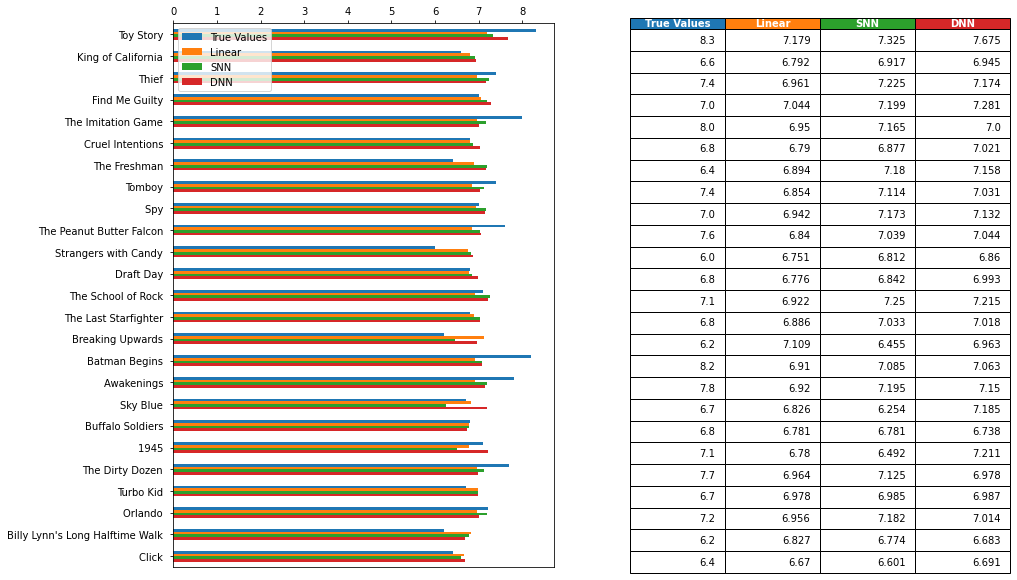

In [16]:
testdf = testvalues(test_set, lin_model, SNN_model, DNN_model)
testdf

In [17]:
#details of each movie
df.iloc[test_set[:][0].index.values]

,title,year,director,genre,country,language,budget,US_box_office,box_office,usr_rating,metacritic
860,Toy Story,1995.0,John Lasseter,Animation,USA,English,0.003000,222498679,404265656,8.3,0.949495
929,King of California,2007.0,Michael A. Cahill,Comedy,USA,English,0.001000,268461,1045786,6.6,0.626263
305,Thief,1981.0,Michael Mann,Action,USA,English,0.000550,11492915,11492915,7.4,0.777778
127,Find Me Guilty,2006.0,Sidney Lumet,Biography,Germany,English,0.001300,1173643,2636637,7.0,0.646465
675,The Imitation Game,2014.0,Morten Tyldum,Biography,UK,English,0.001400,91125683,233555708,8.0,0.727273
489,Cruel Intentions,1999.0,Roger Kumble,Drama,USA,English,0.001050,38773785,76347426,6.8,0.555556
797,The Freshman,1990.0,Andrew Bergman,Comedy,USA,English,0.001200,21460601,21460601,6.4,0.777778
633,Tomboy,2011.0,Céline Sciamma,Drama,France,French,0.000100,129834,1437501,7.4,0.737374
795,Spy,2015.0,Paul Feig,Action,USA,English,0.006500,110825712,235666219,7.0,0.747475
563,The Peanut Butter Falcon,2019.0,Tyler Nilson,Comedy,USA,English,0.000620,20457151,23728475,7.6,0.696970


## Conclusion and discussion
###### Note: conclusion mentions results of my test split, image included below
As it was expected, none of the models outperform others in best predicting the output. Moreover all the models fail at movies with ratings higher than 7.5 or with a very low rating. I've tried to understand why and which variable could be unique for such movies but no clear conclusions has been made. For some cases(in my test split(Toy Story, Sky Blue, 1945)) linear regression and DNN models had similar outputs compared to SNN model. I've tried tuning SNN but nothing changed. As I mentioned at the beginning movie's rating depends on the director's experience, how famous the actors are, maybe music composer's background etc. But including such variables requires a huge dataset where each actor had more than one movie. Unfortunately from the experience in Project-1, my computer and internet connection would have had a trouble collecting such dataset. Overall, I've strengthened my knowledge in training different types of models and had a better understanding of some optimizers and criterions. 
<img src="my_test_train.png">